# TD -  Traitement du signal sur graphes avec Pygsp

Adaptée de la version du TD du cours [Network Tour of Data Science] donné à l'École Polytechnique Féderale de Lausanne (EPFL) : https://github.com/mdeff/ntds_2019

[Mira Rizkallah](https://www.ls2n.fr/annuaire/Mira%20RIZKALLAH/), [LS2N SIMS](https://sims.ls2n.fr)

PyGSP est une librairie populaire pour le traitement du signal sur graphe conçue pour Python. Dans ce Notebook, on apprendra à manipuler des graphes et les signaux résidant sur ces graphes. 

Ceci est un tutoriel sur [PyGSP] (https://github.com/epfl-lts2/pygsp. La librairie PyGSP facilite une grande variété d'opérations sur les graphes, comme le calcul de leur bases de transformée de Fourier, le filtrage ou l'interpolation de signaux, la visualisation de graphes, de signaux et de filtres. La librairie comprend une large gamme de graphes largement utilisés et différents filtres. Outre les modèles prédéfinis, vous pouvez facilement créer un graphe personnalisé en définissant sa matrice d'adjacence ou de poids, et vous pouvez également concevoir des filtres personnalisés en définissant un ensemble de fonctions dans le domaine spectral du graphe.

À l'issue de ce TD, un rapport est demandé (deadline le 22 Février) avec: 
- le code de chaque partie
- Interprétation des résultats
- Réponse aux questions posées. 


On commence par installer la librairie pygsp en utilisant pip ou conda. Pour celà ouvrir un terminal 
ou (le terminal de anaconda) et puis lancer une des deux lignes suivantes: 

Sur un terminal:
pip install pygsp

Sur le terminal d'Anaconda:
conda install -c conda-forge pygsp

Sur google colab: 
!pip install pygsp

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from pygsp import graphs, filters

## 1. La création d'un graphe , les modèles de graphes , les propriétés, la visualisation

Les graphes sont créés par le module [graphs module](https://pygsp.readthedocs.io/en/stable/reference/graphs.html). Il inclut une grande variété de graphes souvent utilisés dans le domaine:
* des modèles déjà construits sur des "manifolds" (des structures sous-jacentes) par exemple;  

`graphs.grid2d()`, `graphs.Bunny()`, `graphs.Swissroll()` etc.  

* des modèles pour générer des graphes aléatoires par exemple;

`graphs.ErdosRenyi()`, `graphs.BarabasiAlbert()`, `graphs.Sensor()`, `graphs.StochasticBlockModel()` etc.

### 1.1 Exemples de modèles prédéfinis

Un exemple d'un graphe prédéfini est le graphe (road network) de Minnesota.

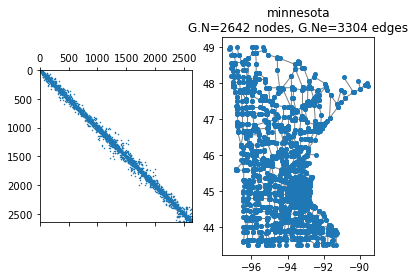

In [3]:
G = graphs.Minnesota()
G.coords.shape # les coordonnées des noeuds sont déjà enregistrés dans le graphe pour la visualisation
fig, axes = plt.subplots(1, 2) 
axes[0].spy(G.W, markersize=0.5) # montrer la matrice d'adjacence 
# A spy plot is a visualisation of a matrix in which there is a dot for each non-zero entry in the matrix.
G.plot(ax=axes[1]) # visualiser le graphe dans le domaine 2D

### 1.2 Construire un graphe de caractéristiques

Les graphes peuvent aussi etre construits d'un ensemble de points appartenant à $\mathbb{R}^d$.

Supposons $\mathbf{X}$ une matrice de données (data matrix) $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$, avec chaque $\mathbf{x} \in \mathbb{R}^d$ est un échantillon pour lequel on a $d$ caractéristiques. Par exemple, des pixels peuvent etre considérés comme des points appartenant à $\mathbb{R}^2$ et les caractéristiques sont les coordonnées des points.

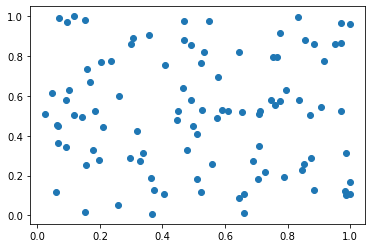

In [4]:
n_points = 100 
dimensionality = 2
points = np.random.uniform(size=(n_points, dimensionality))
plt.scatter(points[:, 0], points[:, 1]);

**1. Choisir le type de connectivité utilisée :**
* kNN graph (chaque noeud est connecté à ses k plus proches voisins)
* $\epsilon$ - radius graph (chaque noeud est connecté à tout autre noeud dans un rayon $\epsilon$

**2. Définir les poids des connections avec un noyau gaussien** 
$$\mathbf{W}[i,j] = \exp(-\frac{||\mathbf{x}_i - \mathbf{x}_j||^2_2 }{ \sigma^2})$$ 

In [36]:
sigma = 0.01

In [37]:
G_NN = graphs.NNGraph(points, NNtype='knn', k=2, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G_NN.N} nodes, {G_NN.Ne} edges')

100 nodes, 125 edges


100 nodes, 136 edges


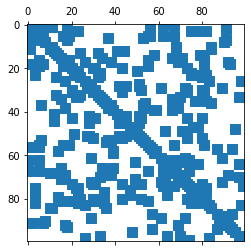

In [38]:
G_NN = graphs.NNGraph(points, NNtype='radius', epsilon=0.1, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G_NN.N} nodes, {G_NN.Ne} edges')
plt.spy(G_NN.L)

**Question:**

En variant la valeur de $\sigma$, observez le nombre de connections existantes. Commentez les résultats

**Réponse** : On observe que plus la valeur de $\sigma$ diminue, plus le nombre de connections sera faible. On note aussi la présence d'un nombre maximal de connections. A partir d'une certaine valeur de $\sigma$, le nombre de connections n'augmente plus.

### 1.2 Graphe créé à partir d'une matrice d'adjacence (de poids)

100 nodes, 194 edges
Connected: False
Directed: False


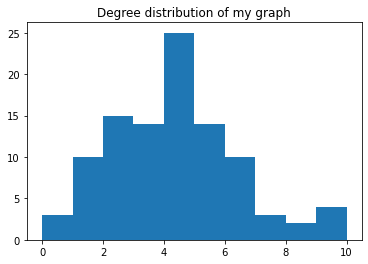

In [42]:
W = sparse.random(100, 100, 0.02)  # Sparse graphe
W.setdiag(0) 
W = W + W.T

G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

# Pour voir si le graphe est connecté, donc si de chaque noeud du graphe on peut atteindre nimporte quel autre noeud en suivant les connections du graphe.
print('Connected: {}'.format(G.is_connected())) 

# Un graphe est orienté si:
# la matrice W n'est pas symétrique (W_ij = 1 ssi il existe une connection qui part de i vers j).
print('Directed: {}'.format(G.is_directed()))


# hist est utilisé pour tracer l'histogramme
plt.hist(G.d)
plt.title('Degree distribution of my graph');

**Question:**

Interpréter les $3$ premières lignes du code précédent (en cherchant entre autre ce que fait la fonction sparse.random ..). À quoi ressemble la matrice $\mathbf{W}$ à votre avis? 

**Réponse :** La fonction `sparse.random`crée dans ce cas une matrice de taille 100x100 avec une densité égale à 0.02. On aura beacoup de valeurs nulles car cette valeur de densité est faible. Après ces 3 lignes, la matrice W contient donc beacoup de valeurs nulles (dont celles diagnoales) et elle est symétrique.

### 1.3 La visualisation d'un graphe

Pour pouvoir visualiser un graphe, nous devons intégrer ses nœuds dans un espace 2D ou 3D. Le processus pour trouver les coordonnées de chaque noeud est appelé [layout](https://en.wikipedia.org/wiki/Graph_drawing). Pour la plupart des modèles de graphes inclus dans la librairie, les coordonnées des points sont définis automatiquement et enregistrés dans `G.coords`. 

Si ce n'est pas le cas, ou si vous créez le graphe à partir d'une matrice d'adjacence, la fonction [`pygsp.graphs.Graph.set_coordinates ()`](https://pygsp.readthedocs.io/en/stable/reference/graphs.html # pygsp.graphs.Graph.set_coordinates) peut être utilisée pour définir le domaine de définition des noeuds et leurs coordonnées sur ce domaine.

Dans notre exemple de graphes de caractéristiques, les noeuds avaient une structure sous-jacente 2D naturelle. Par conséquent, le graphe est automatiquement visualisé (tracé) en utilisant:
- les coordonnées 2D qui définissent les points (noeuds) 
- le type de connectivité sélectionnée qui définissent les connections entre les noeuds

D:\Appli\Anaconda\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


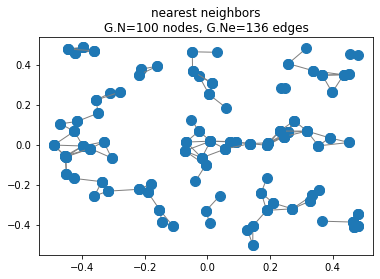

In [43]:
G_NN.plot()

Contrairement au cas précedent, la visualisation du graphe créé à partir d'une matrice d'adjacence nécessite ce qu'on appelle un "embedding" des noeuds. Il faut donc définir les coordonnées des noeuds dans un espace sous-jacent (2D ou 3D). 

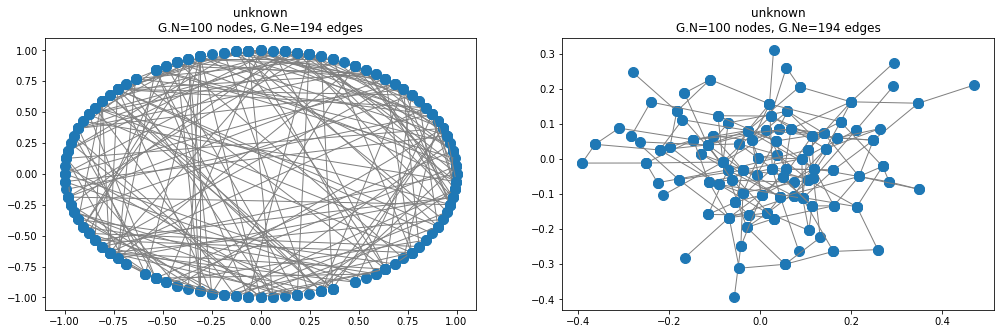

In [44]:
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

G.set_coordinates('ring2D')
G.plot(ax=axes[0])

G.set_coordinates('spring')
G.plot(ax=axes[1])

## 2. La théorie spectrale du graphe 

On va maintenant s'interresser à la théorie spectrale du graphe. Pour celà, on va prendre un exemple d'un graphe de communautés en utilisant le modèle de bloc stochastique et on va faire son analyse spectrale. Le modèle de bloc stochastique est un modèle de graphe aléatoire avec $4$ paramètres: 
- le nombre de noeuds dans le graphe: $N$ 
- le nombre de communautés formées dans le graphe: $k$
- la probabilité $p$ qu'une connection existe entre deux noeuds au sein d'une communauté
- la probabilité $q$ pour qu'une connection existe entre deux noeuds appartenante à différentes communautés

In [89]:
G = graphs.StochasticBlockModel(N=200, k=2, p=0.1, q=0.0)

Afin de visualiser les communautés, on peut illustrer le modèle de parcimonie de la matrice d'adjacence, ou même visualiser le graphe et la connectivité entre les noeuds. 

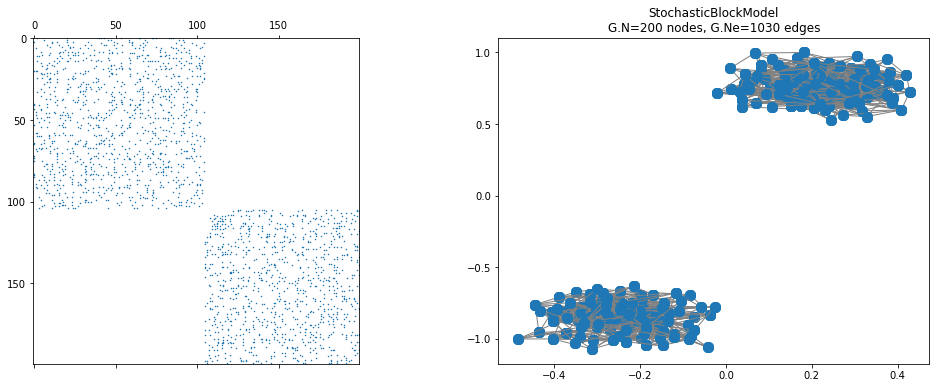

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].spy(G.W, markersize=0.5)
G.set_coordinates(kind='spring')
G.plot(ax=axes[1])

**Question:**

Variez le nombre de communautés $k$ ainsi que les probabilités $p$ et $q$, et interpréter les résultats quant à la parcimonie de la matrice d'adjacence et le graphe visualisé. 

**Réponse :** 

* `k`correspond au nombre de communautés donc, en particulier, au nombre de blocs dans la matrice d'adjacence
* Plus `p`est faible, moins il y aura de connectiosn entre les noeuds d'une même communauté. Ces connections correspondent aux blocs dans la matrice d'adjacence.
* Plus `q`est faible, moins il y aura de connections entre les noeuds de différentes communautés. Ces connections correspondent aux points isolés dans la figure de gauche.
* Le paramètre `q` permet de jouer sur la parcimonie de la matrice d'adjacence.

Afin de faire l'analyse spectrale sur un graphe,on commence par calculer la décomposition en vecteurs et valeurs propres du laplacien. Le Laplacian non normalisé (combinatorial) d'un graphe est défini par : $L = D − W$,
avec $D$ la matrice diagonale avec les degrés des noeuds sur la diagonale. 
On peut alternativement définir le laplacian normalisé : $L_{norm} = D^{-1/2} L D^{-1/2}$

Commençons par calculer la matrice laplacienne et la visualiser:

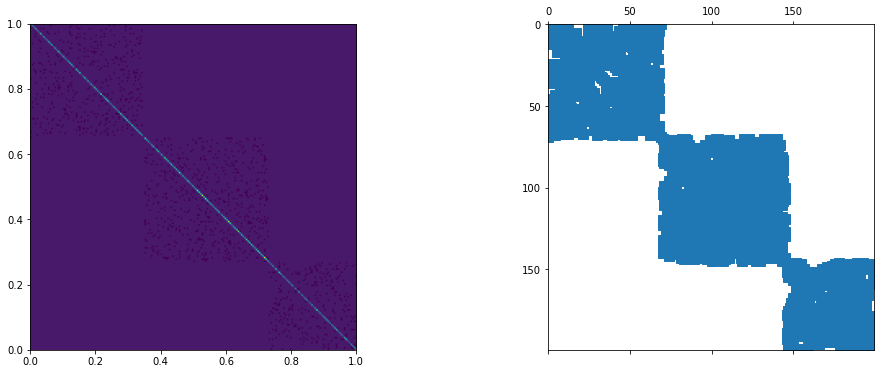

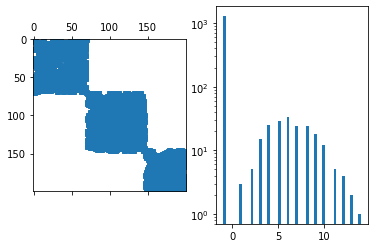

In [62]:
G.compute_laplacian('combinatorial') 
fig, axes = plt.subplots(1, 2, figsize=(17, 6))
axes[0].imshow(G.L.todense(),extent=[0, 1, 0, 1])
axes[1].spy(G.L)

fig, axes = plt.subplots(1, 2) 
axes[0].spy(G.L, markersize=5) 
axes[1].hist(G.L.data, bins=50, log=True);

**Questions:**

- Relancer le code précédent avec le laplacien normalisé en utilisant `G.compute_laplacian('normalized')`. 

- Quelle différences observez vous avec le cas du laplacien non normalisé ?  

**Réponse :** On observe que pour le laplacien normalisé, on obtient que des 1 sur la diagonale, ce qui n'est pas le cas pour la laplacien non normalisé.

### 2.1 Le spectre d'un graphe

On s'interresse maintenant aux valeurs propres du laplacien de ce graphe. Rappelons-nous que pour les matrices parcimonieuses (sparse), on utilise généralement des méthodes de décompositions optimisées du module `sparse` de la librairie `scipy` afin d'obtenir les $k$ premiers vecteurs et valeurs propres, da la manière suivante:

In [90]:
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')

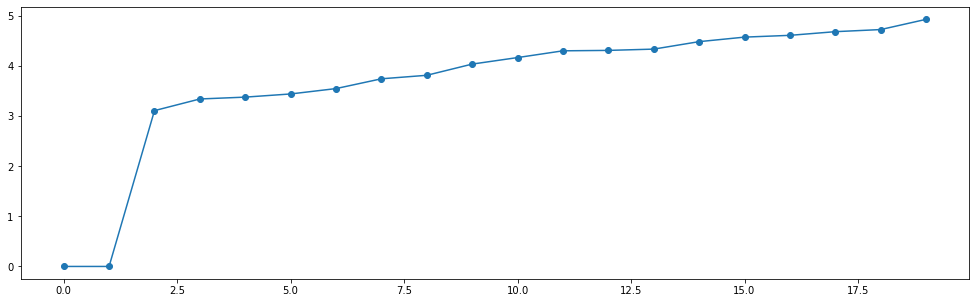

In [91]:
plt.figure(figsize=(17, 5))
plt.plot(eig_val, 'o-');
# l'argument '+-' c'est juste pour définir le style de la ligne qu'on visualise, vous pouvez essayer '--' 'r+-' '+-'

### 2.2 Les graphes non connectés et la propriété sur le spectre

Reprendre le graphe de communautés en utilisant le modèle de bloc stochastique mais cette fois-ci en définissant la probabilité $q = 0$, et puis en variant le nombre $k$. Par exemple essayer $k = 2$, $k = 3$, $k = 4$ ... Regarder ce qui se passe dans le spectre. 

**Question:** 
    
- Quel est Le nombre de graphes disjoints dans les différents cas? 

- Avez vous remarqué un changement dans le spectre du graphe $G$? 

- Conclure sur une propriété du spectre du graphe qui dépend du nombre de graphes disjoints (connected components) 

**Réponse :** 

* Il y a `k` graphes disjoints
* On observe que plus la valeur de `k` augmente, plus le spectre contient des valeurs nulles
* Ainsi, la priorieté correspondant au nombre de valeurs propres nulles dépend du nombre de graphes disjoints

### 2.3 Vecteurs propres du laplacien : La notion de fréquence sur un graphe

On va maintenant visualiser les fréquences sur le graphe, en visualisant les différents vecteurs propres. On utilise la commande: `graphs.plot_signal()`:

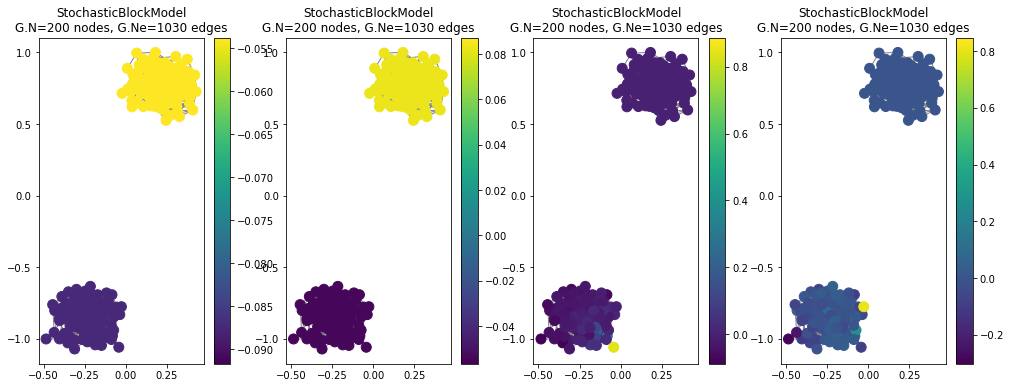

In [93]:
fig, axes = plt.subplots(1, 4, figsize=(17, 6))
G.plot_signal(U[:, 0], ax=axes[0])
G.plot_signal(U[:, 1], ax=axes[1])
G.plot_signal(U[:, 2], ax=axes[2])
G.plot_signal(U[:, 3], ax=axes[3])

On va maintenant visualiser nos noeuds sur un espace de faible dimension (en anglais: low dimensional embedding) dicté par les vecteurs propres du Laplacien. Le premier vecteur propre, étant constant ne nous interesse pas. On va donc visualiser chaque noeud $i$ en 2D avec les coordonnées suivantes $(u_2(i), u_3(i))$:

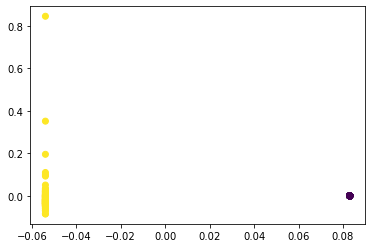

In [94]:
plt.scatter(U[:, 1], U[:, 2], c=G.info['node_com'])

**Exercise**:

Visualiser les $5$ ou $10$ premiers vecteurs propres d'un graphe cyclique (ring graph) en fonction des valeurs propres. Qu'observez-vous? reconnait-on les fréquences? 

* utiliser `G = graphs.Ring(N=50)`

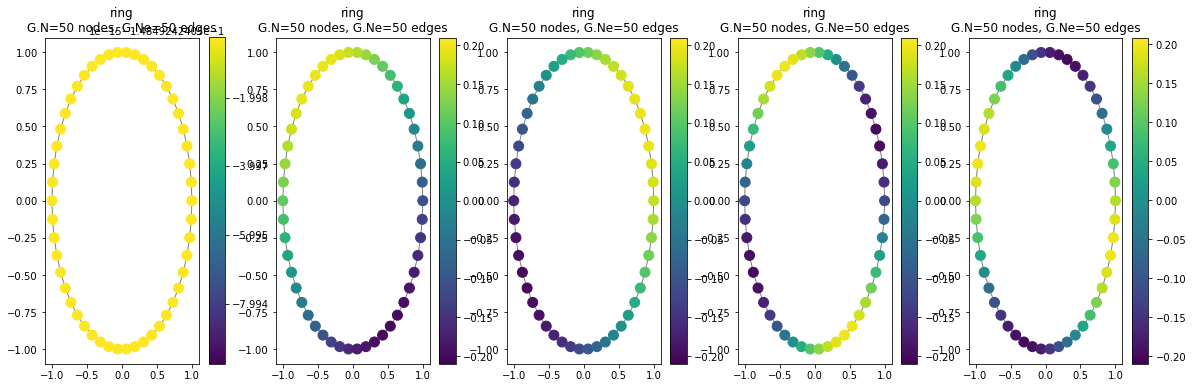

In [101]:
G = graphs.Ring(N=50)
eig_val, U = sparse.linalg.eigsh(G.L, k=20, which='SM')

fig, axes = plt.subplots(1, 5, figsize=(20, 6))
G.plot_signal(U[:, 0], ax=axes[0])
G.plot_signal(U[:, 1], ax=axes[1])
G.plot_signal(U[:, 2], ax=axes[2])
G.plot_signal(U[:, 3], ax=axes[3])
G.plot_signal(U[:, 4], ax=axes[4])

On observe ainsi les différentes fréquences à travers les changements de couleurs sur l'anneau.

## 3. La définition d'un signal sur le graphe, la mesure de "smoothness" et la transformée de Fourier

### 3.1 La définition d'un signal
On va maintenant générer un signal aléatoire qui réside sur les noeuds du graphe $G$

D:\Appli\Anaconda\lib\site-packages\pygsp\plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


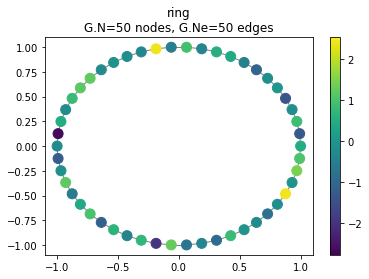

In [102]:
signal = np.random.normal(size=G.N)
G.plot_signal(signal)

### 3.2 Smoothness

La "smoothness" (ou aussi la variation du signal sur un graphe) d'un signal peut être calculée par la forme quadratique du laplacien:

$$ f^\intercal L f = \| \nabla_\mathcal{G} f \|_2^2 = \sum_{i \sim j} W_{ij} (f_j - f_i)^2 $$

La forme quadratique est généralement normalisée par le carré de la norme du signal si on veut comparer d'une façon juste la "smoothness" de deux signaux différents.

In [103]:
signal.T @ G.L @ signal

115.27773393600339

### 3.3 Graph Fourier Transform

Comme la la transformée de Fourier classique, la GFT transforme le signal du graphe du domaine spatial des noeuds vers le domaine spectral du graphe. Examinons les coefficients de Fourier d'un signal aléatoire $f$ sur un graphe de communauté créé d'une autre façon. 

2022-02-07 11:40:17,233:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.5900200641113513


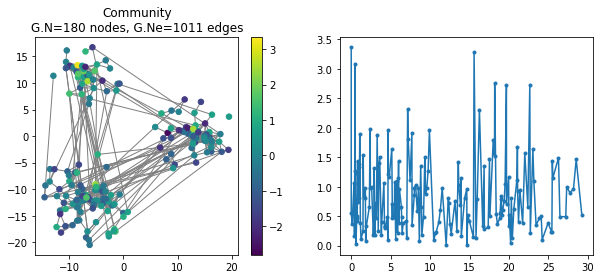

In [104]:
communities = [40, 80, 60]
G = graphs.Community(N=180, Nc=3, comm_sizes=communities) 
f = np.random.normal(size=G.N)
G.compute_fourier_basis()
f_hat = G.gft(f)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(f, vertex_size=30, ax=axes[0]) 
axes[1].plot(G.e, np.abs(f_hat), '.-')

**Question:** 
    
- Commenter la "smoothness" du signal en se basant sur les coefficients de la transformée de Fourier ?

**Bonus:** 
    
- Montrer que la forme quadratique du laplacien peut s'écrire de la forme suivante: 

$$ f^\intercal L f = \sum_{l} \lambda_l \hat{f}_l^2 $$

avec $\{\hat{f}_l\}$ étant l'ensemble des coefficients de la transformée de Fourier du signal f sur le graphe $G$.

**Réponse :** Ce signal n'est pas du tout "smooth". En effet, on observe de grandes variations entre les valeurs des différents coefficients de la transformée de Fourier.

On définit maintenant un autre signal sur le graphe, une fonction de partition comme suit:
$$ x[i] =
\begin{cases}
    -1 &\text{if } i \in C_1, \\
    0  &\text{if } i \in C_2, \\
    1  &\text{if } i \in C_3,
\end{cases}
$$
avec $C_i$ l'ensemble de noeuds dans la $i$ème communauté.

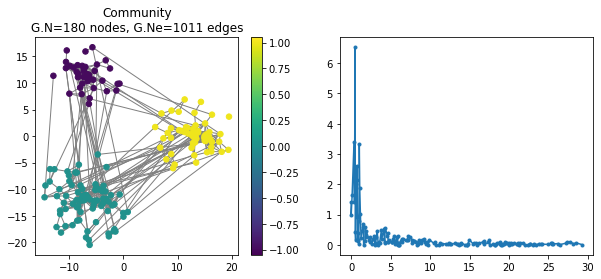

In [107]:
fp = np.zeros(G.N)
fp[:communities[0]] = -1 * np.ones(communities[0]) 
fp[-communities[-1]:] = 1 * np.ones(communities[-1])

G.compute_fourier_basis()
fp_hat = G.gft(fp)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
G.plot_signal(fp, vertex_size=30, ax=axes[0]) 
axes[1].plot(G.e, np.abs(fp_hat), '.-')

**Question:** 

- Visualiser $f$ and $fp$ sur le graphe. Qu'observez-vous? 
- Calculer les coefficients de la transformée de Fourier de $fp$ and comparer with ceux of $f$. Qu'observez-vous et pourquoi?
- Comparer la forme quadratique du laplacien de $f$ and $fp$. Ceci est-il consistent avec ce qu'on observe sur la transformée de fourier de ces deux signaux?  (NB: pour une comparaison juste, on divise la forme quadratique du laplacien par le carré de la norme du signal)

On observe que :

* fp est constant sur les communautés, par définition tandis que ce n'est pas du tout le cas pour  $f$.
* les coefficients de la transformée de Fourier de $fp$ sont faibles et varient peu (smoothness) contrairement à ceux de $f$ affichés plus haut